In [7]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os

# define parameters
- $\bf{F}$: state transition matrix ($n\times n$)
- $\vec{x}$: state vector ($n\times 1$)
- $\bf{P}$: state covariance matrix ($n\times n$)
- $\bf{Q}$: process noise covariance matrix ($n\times n$)
- $\bf{H}$: measurement covariance matrix ($m\times n$)
- $\vec{z}$: measurement vector ($m\times 1$)
- $\bf{K}$: Kalman Gain Matrix ($n\times m$)

## Kalman filter using pressure measurements
##### TODO: 
#####      - look at covariance matrices
#####      - look at correct spiral geometry

In [8]:
# Checking and printing the current working directory
print(f"Current Working Directory: {os.getcwd()}")

# Define file path relative to the current working directory
data_file_path = "../utils/labeled_position_data/spiral_1_loop.csv"
full_data_file_path = os.path.join(os.getcwd(), data_file_path)

# Checking if the path exists
if not os.path.exists(full_data_file_path):
    print(f"File not found: {full_data_file_path}")
else:
    print(f"Found file: {full_data_file_path}")

# Reading the CSV file
df = pd.read_csv(full_data_file_path)

Current Working Directory: C:\Users\diete\OneDrive - KU Leuven\Academiejaar 2024-2025\SPAI\Project\Helixon\RaD_team1_HELIXON\kalman
Found file: C:\Users\diete\OneDrive - KU Leuven\Academiejaar 2024-2025\SPAI\Project\Helixon\RaD_team1_HELIXON\kalman\../utils/labeled_data/spiral_1_loop.csv


In [9]:
kf = KalmanFilter(dim_x=6, dim_z=3)
kf.x = np.array([0, 0, 0, 0, 0, 0])
dt = 0.04 # 25Hz samples
kf.F = np.array([
    [1, 0, 0, dt, 0, 0],
    [0, 1, 0, 0, dt, 0],
    [0, 0, 1, 0, 0, dt],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])

kf.H = np.array([
    [1, 0, 0, 0, 0, 0],  
    [0, 1, 0, 0, 0, 0],  
    [0, 0, 1, 0, 0, 0]   
])

q = 0.005
kf.Q = np.array([
    [q, 0, 0, 0, 0, 0],
    [0, q, 0, 0, 0, 0],
    [0, 0, q, 0, 0, 0],
    [0, 0, 0, q, 0, 0],
    [0, 0, 0, 0, q, 0],
    [0, 0, 0, 0, 0, q]
])

kf.R = np.eye(3)*5 

kf.P *= 1000

In [10]:
def z_to_xy(z):
    # Calculate the angle theta at height z
    x = -8.25 * np.cos((2 * np.pi * 3.2 / 14.5) * z)
    y = 8.25 * np.sin((2 * np.pi * 3.2 / 14.5) * z)
    return x, y

measured_x, measured_y, measured_z = [], [], []
predicted_x, predicted_y, predicted_z = [], [], []

P_0 = 0
for i in range (20):
    P_0 += (1/20)*df['Pressure'][i] 

for i, row in df.iterrows():
    P = row['Pressure']
    T = row['Temperature']
    z = -(8.3144598 * (T + 273.15)) / (0.0289644 * 9.80665) * np.log(P / P_0)
    x, y = z_to_xy(z)
    kf.predict()
    kf.update([x, y, z])
    
    measured_x.append(x)
    measured_y.append(y)
    measured_z.append(z)
    predicted_x.append(kf.x[0])
    predicted_y.append(kf.x[1])
    predicted_z.append(kf.x[2])

predicted_x = np.array(predicted_x)
predicted_y = np.array(predicted_y)
predicted_z = np.array(predicted_z)
measured_x = np.array(measured_x)
measured_y = np.array(measured_y)
measured_z = np.array(measured_z)

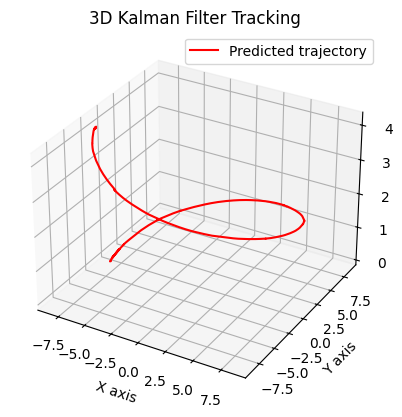

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(predicted_x, predicted_y, predicted_z, 'r', label='Predicted trajectory')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('3D Kalman Filter Tracking')
ax.legend()

plt.show()

4.280858475561105


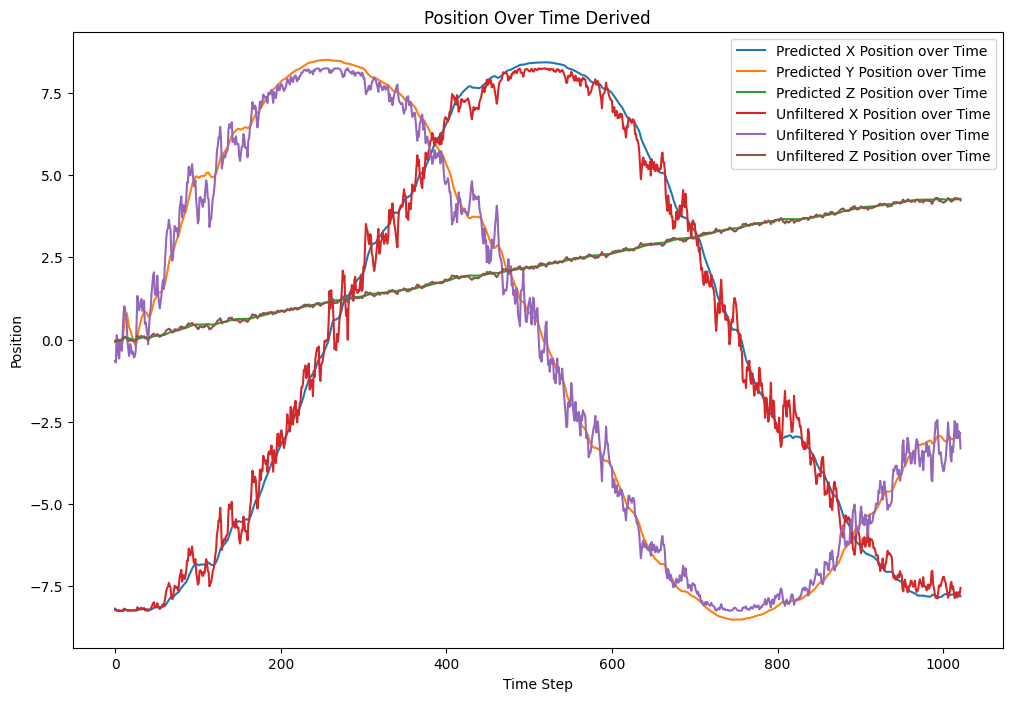

In [12]:
print(max(predicted_z))
#1 LOOP: 4,19
#2 LOOP: 8,43

#Plot positions over time
plt.figure(figsize=(12, 8))
plt.plot(predicted_x, label='Predicted X Position over Time')
plt.plot(predicted_y, label='Predicted Y Position over Time')
plt.plot(predicted_z, label='Predicted Z Position over Time')
plt.plot(measured_x, label='Unfiltered X Position over Time')
plt.plot(measured_y, label='Unfiltered Y Position over Time')
plt.plot(measured_z, label='Unfiltered Z Position over Time')
plt.title('Position Over Time Derived')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()

